In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping

In [2]:
path = './malimg_dataset/'

In [3]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 1 classes.


In [4]:
familias.class_indices

{'malimg_paper_dataset_imgs': 0}

In [5]:
imgs, labels = next(familias)

In [6]:
imgs.shape

(9339, 64, 64, 3)

In [7]:
labels.shape

(9339, 1)

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [9]:
!pip show keras
!pip show tensorflow

Name: keras
Version: 2.13.1
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: 
Required-by: tensorflow-intel
Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: tensorflow-intel
Required-by: 


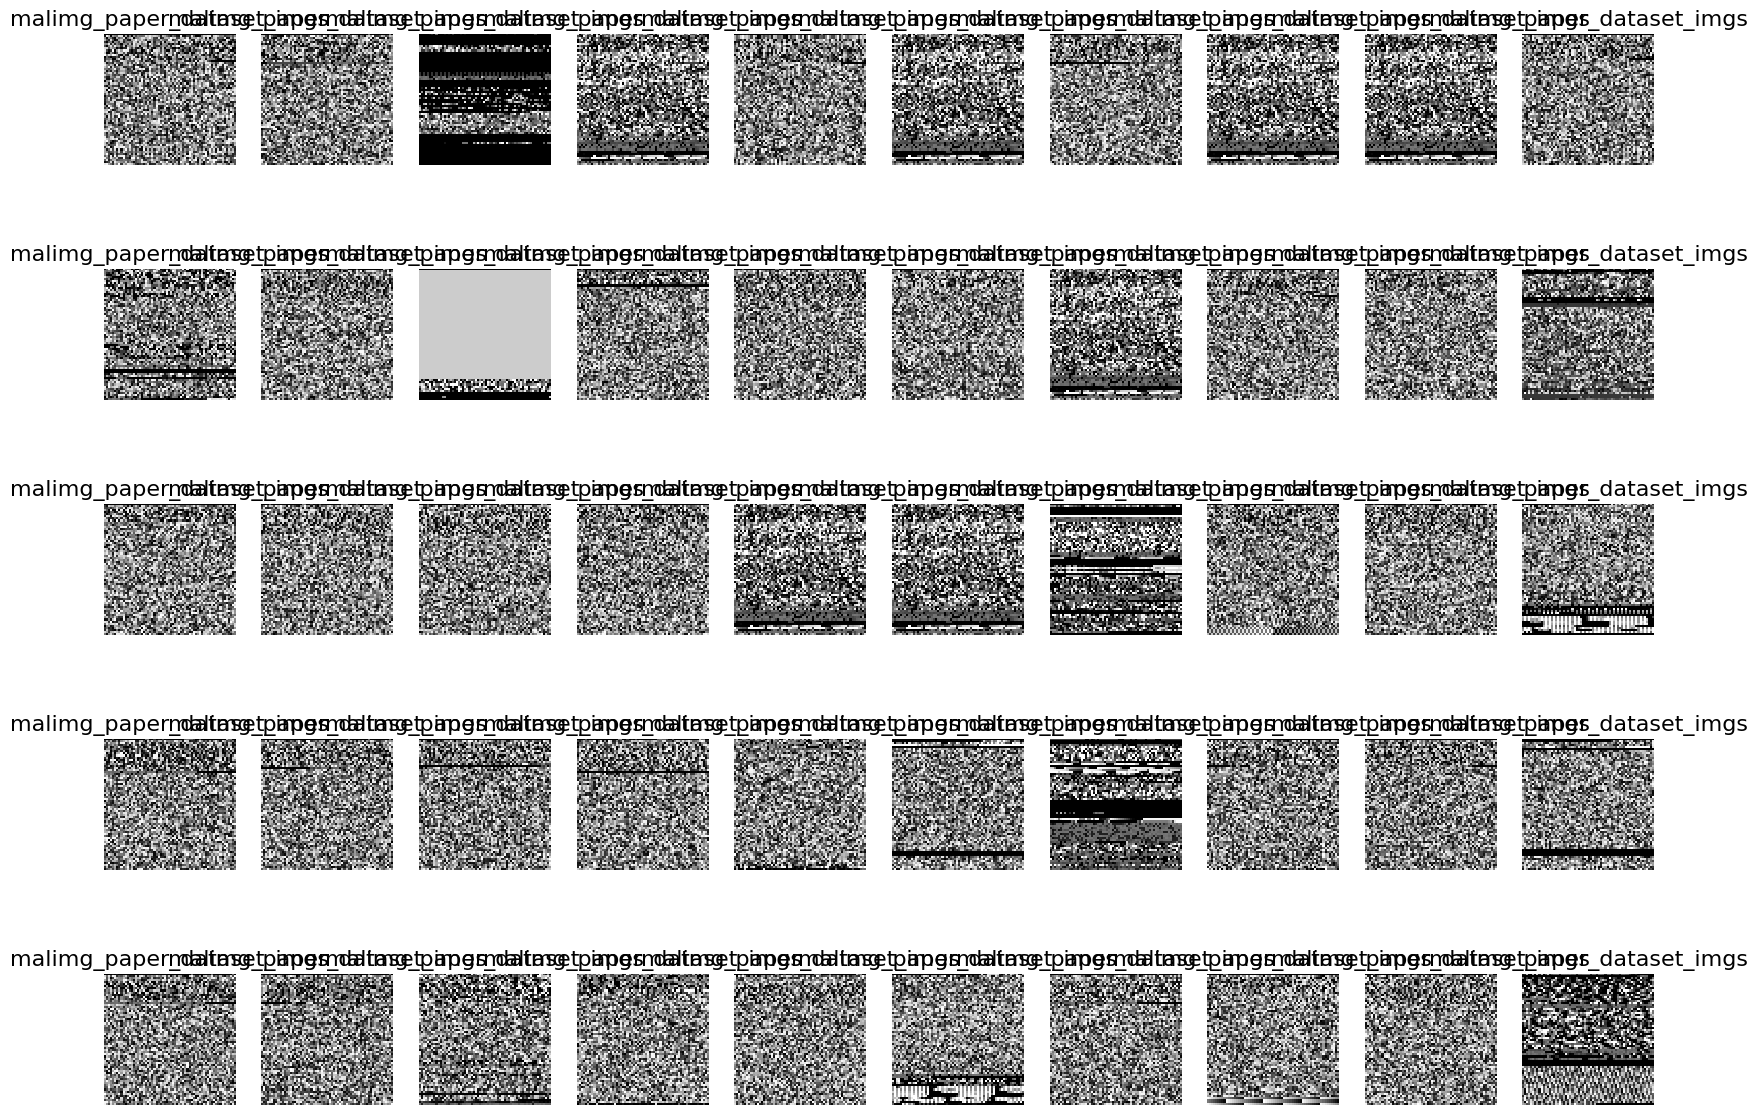

In [10]:

plots(imgs, titles = labels)

### Primera parte

Pre preprocesamiento adicional

Conteo de observaciones

In [11]:
# Path al directorio con las imágenes
path = './malimg_dataset/'

# Creando un generador de datos con escalamiento de las imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargando imágenes desde el directorio
generator = datagen.flow_from_directory(
    directory=path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Obteniendo las etiquetas de las clases del generador
class_indices = generator.class_indices
class_counts = {class_name: 0 for class_name in class_indices.keys()}

# Contando el número de imágenes por clase
for _, labels in generator:
    for label in labels:
        class_name = list(class_indices.keys())[np.argmax(label)]
        class_counts[class_name] += 1
    if generator.batch_index == 0:
        break

print("Conteo de observaciones por familia de malware:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Found 9339 images belonging to 1 classes.
Conteo de observaciones por familia de malware:
malimg_paper_dataset_imgs: 9339


Dividiendo la data en 70% train y 30% test

In [12]:
all_images = []
all_labels = []

# Cargando todas las imágenes y etiquetas
for _ in range(generator.samples // generator.batch_size + 1):
    imgs, labels = next(generator)
    all_images.append(imgs)
    all_labels.append(labels)

# Concatenando todas las imágenes y etiquetas en un solo array
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Asegurándose de no tener más datos de los necesarios
all_images = all_images[:generator.samples]
all_labels = all_labels[:generator.samples]

In [13]:
# Dividiendo los datos en un conjunto de entrenamiento y otro de prueba
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)

print(X_train, X_test)

[[[[0.8941177  0.8941177  0.8941177 ]
   [0.00392157 0.00392157 0.00392157]
   [0.27058825 0.27058825 0.27058825]
   ...
   [0.         0.         0.        ]
   [0.07450981 0.07450981 0.07450981]
   [0.00784314 0.00784314 0.00784314]]

  [[0.27450982 0.27450982 0.27450982]
   [0.14117648 0.14117648 0.14117648]
   [0.         0.         0.        ]
   ...
   [0.2901961  0.2901961  0.2901961 ]
   [0.05882353 0.05882353 0.05882353]
   [0.01568628 0.01568628 0.01568628]]

  [[0.5176471  0.5176471  0.5176471 ]
   [0.92549026 0.92549026 0.92549026]
   [0.35686275 0.35686275 0.35686275]
   ...
   [0.3137255  0.3137255  0.3137255 ]
   [0.76470596 0.76470596 0.76470596]
   [0.01568628 0.01568628 0.01568628]]

  ...

  [[0.7137255  0.7137255  0.7137255 ]
   [0.8000001  0.8000001  0.8000001 ]
   [0.         0.         0.        ]
   ...
   [0.41176474 0.41176474 0.41176474]
   [0.43921572 0.43921572 0.43921572]
   [0.47450984 0.47450984 0.47450984]]

  [[0.42352945 0.42352945 0.42352945]
   [0.1

In [14]:
print("Shape of X_train:", X_train.shape)

Shape of X_train: (6537, 64, 64, 3)


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=3, activation="relu", input_shape=(64, 64, 3)),  
        MaxPooling2D(pool_size=2),
        BatchNormalization(),  # Batch Normalization después de la primera capa de convolución
        Conv2D(64, kernel_size=3, activation="relu"),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),  # Batch Normalization después de la segunda capa de convolución
        Flatten(),
        Dense(128, activation="relu", 
              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)),  
        Dropout(0.9),  # Ajustando la tasa de dropout
        Dense(10, activation="softmax")
    ])

    # Compilando el modelo con regularización L1 y L2
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [16]:
from keras.utils import to_categorical

# Convertiendo las etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Creando el modelo
model = create_model()

model.fit(X_train, y_train, epochs=5, batch_size=256)

model.save("model.h5")

Epoch 1/5
26/26 [==============================] - 15s 515ms/step - loss: 17.7933 - accuracy: 0.7450
Epoch 2/5
26/26 [==============================] - 14s 522ms/step - loss: 12.0781 - accuracy: 0.9495
Epoch 3/5
26/26 [==============================] - 14s 536ms/step - loss: 6.9469 - accuracy: 0.9732
Epoch 4/5
26/26 [==============================] - 14s 531ms/step - loss: 3.5753 - accuracy: 0.9797
Epoch 5/5
26/26 [==============================] - 14s 527ms/step - loss: 1.8286 - accuracy: 0.9862


c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Segunda parte

In [17]:
!pip install adversarial-robustness-toolbox

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Cargando el modelo

In [18]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier

# Desactivando la ejecución ansiosa
tf.compat.v1.disable_eager_execution()

# Cargando el modelo
model = load_model('model.h5')

# Envolviendo el modelo con ART
classifier = KerasClassifier(model=model)

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instructions for updating:
Colocations handled automatically by placer.


**Ataque de evasión**

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.models import Sequential
import numpy as np
from art.attacks.evasion import FastGradientMethod
from sklearn.metrics import accuracy_score

def create_denoising_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2DTranspose(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(3, (3, 3), padding='same', activation='sigmoid')  # Assuming the input images are normalized [0, 1]
    ])
    return model

noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)
denoising_model = create_denoising_model()
denoising_model.compile(optimizer='adam', loss='mean_squared_error')
denoising_model.fit(X_train_noisy, X_train, epochs=5, batch_size=256, validation_data=(X_test_noisy, X_test))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.001)
x_test_adv = attack_fgsm.generate(x=X_test)
if len(y_test.shape) > 1: 
    y_test = np.argmax(y_test, axis=1)
predictions_normal = classifier.predict(X_test)
if len(predictions_normal.shape) > 1:
    predictions_normal = np.argmax(predictions_normal, axis=1)
accuracy_normal = accuracy_score(y_test, predictions_normal)
print(f"Accuracy en datos normales: {accuracy_normal * 100:.2f}%")
predictions = classifier.predict(x_test_adv)
if len(predictions.shape) > 1:
    predictions = np.argmax(predictions, axis=1)
accuracy_fgsm = accuracy_score(y_test, predictions)
print(f"Accuracy en datos de ataque FGSM: {accuracy_fgsm * 100:.2f}%")
x_test_adv_denoised = denoising_model.predict(x_test_adv)
predictions_denoised = classifier.predict(x_test_adv_denoised)
if len(predictions_denoised.shape) > 1:
    predictions_denoised = np.argmax(predictions_denoised, axis=1)
accuracy_denoised = accuracy_score(y_test, predictions_denoised)
print(f"Accuracy en datos de ataque después de denoising: {accuracy_denoised * 100:.2f}%")

Train on 6537 samples, validate on 2802 samples
Epoch 1/5
6537/6537 [==============================] - ETA: 0s - loss: 0.0687

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6537/6537 [==============================] - 79s 12ms/sample - loss: 0.0687 - val_loss: 0.0972
Epoch 2/5
6537/6537 [==============================] - 78s 12ms/sample - loss: 0.0498 - val_loss: 0.0967
Epoch 3/5
6537/6537 [==============================] - 79s 12ms/sample - loss: 0.0471 - val_loss: 0.0904
Epoch 4/5
6537/6537 [==============================] - 76s 12ms/sample - loss: 0.0459 - val_loss: 0.0847
Epoch 5/5
6537/6537 [==============================] - 77s 12ms/sample - loss: 0.0452 - val_loss: 0.0768


c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy en datos normales: 87.90%
Accuracy en datos de ataque FGSM: 87.29%


c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy en datos de ataque después de denoising: 99.96%


**Explicación del ataque de evasión:**

El código que se tiene en la celda pertenece a un ataque adversario usando el método de "Fast Gradient Sign Method (FGSM) por medio de la librería ART (Adversarial Robustness Toolbox) en Python. Primero, importo la librería FGSM y configuro el modelo "classifier" a atacar y la magnitud del ataque (en este caso un eps de 0.1). Luego, se generan imágenes adversarias y se asignan a la variable "x_test_adv" modificando así las imágenes de prueba de la variable "X_test" con el objetivo de engañar al modelo.

El modelo se evalúa primero en las imágenes originales de prueba para obtener una línea base de precisión (o sea el "accuracy_normal"), enseñando así como se desempeña el modelo en condiciones normales. Finalmente, se evalúa la precisión del modelo con las imágenes adversarias para ver como afecta el ataque FGSM a su rendimiento ayudando a entender la robustez del modelo ante ataques adversarios. Este proceso es altamente importante para la seguridad en modelos de aprendizaje automático, permitiendo así identificar y mejorar su resistencia frente a manipulaciones malintencionadas.

**Explicación del modelo denoising**

La defensa que se aplicó al modelo consiste en un modelo de denoising que está diseñado directamente para limpiar limpiar imágenes que fueron alteradas por un ataque adversario, que en este caso fue el Fast Gradient Sign Method (FGSM). Este modelo de denoising se entrena primero con un conjunto de datos donde las imágenes originales han sido artificialmente ruidosas, aprendiendo así a restaurar estas imágenes a su estado limpio y original. Luego, después de que el modelo clasificador ha sido desafiado con imágenes adversarias generadas por el ataque FGSM, estas imágenes alteradas se procesan a través del modelo denoising para intentar eliminar las perturbaciones adversarias antes de ser re-evaluadas por el modelo clasificador. El objetivo de la defensa aplicada en esta ocasión es mejorar de alguna manera la precisión del clasificador en presencia de ataques adversarios, demostrando la efectividad del modelo de denoising en la protección contra manipulaciones específicas diseñadas para engañar al clasificador.

**Explicación del ataque de evasión:**

El código que se tiene en la celda pertenece a un ataque adversario usando el método de "Fast Gradient Sign Method (FGSM) por medio de la librería ART (Adversarial Robustness Toolbox) en Python. Primero, importo la librería FGSM y configuro el modelo "classifier" a atacar y la magnitud del ataque (en este caso un eps de 0.1). Luego, se generan imágenes adversarias y se asignan a la variable "x_test_adv" modificando así las imágenes de prueba de la variable "X_test" con el objetivo de engañar al modelo.

El modelo se evalúa primero en las imágenes originales de prueba para obtener una línea base de precisión (o sea el "accuracy_normal"), enseñando así como se desempeña el modelo en condiciones normales. Finalmente, se evalúa la precisión del modelo con las imágenes adversarias para ver como afecta el ataque FGSM a su rendimiento ayudando a entender la robustez del modelo ante ataques adversarios. Este proceso es altamente importante para la seguridad en modelos de aprendizaje automático, permitiendo así identificar y mejorar su resistencia frente a manipulaciones malintencionadas.

**Ataque de extracción**

In [21]:

import numpy as np
import tensorflow as tf
from art.estimators.classification import KerasClassifier
from art.attacks.extraction import CopycatCNN
from sklearn.metrics import accuracy_score

def add_gaussian_noise(predictions, sigma=0.1):
    noise = np.random.normal(0, sigma, predictions.shape)
    return np.clip(predictions + noise, 0, 1)

model_victim = tf.keras.models.load_model('model.h5')

classifier_victim = KerasClassifier(model=model_victim, clip_values=(0, 1))

def predict_with_noise(classifier, X):
    predictions = classifier.predict(X)
    return add_gaussian_noise(predictions)

thieved_model = create_model()

thieved_classifier = KerasClassifier(model=thieved_model, clip_values=(0, 1))

X_data = np.random.rand(100, 64, 64, 3) 

attack = CopycatCNN(classifier=classifier_victim, batch_size_fit=32, batch_size_query=32, nb_epochs=10, nb_stolen=100)

thieved_classifier = attack.extract(x=X_data, thieved_classifier=thieved_classifier)

predictions = predict_with_noise(classifier_victim, X_test)

if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)

if len(predictions.shape) > 1:
    predictions = np.argmax(predictions, axis=1)

predictions_original = classifier_victim.predict(X_test)
if len(predictions_original.shape) > 1:
    predictions_original = np.argmax(predictions_original, axis=1)

accuracy_original = np.mean(predictions_original == y_test)
print(f"Accuracy of the original model: {accuracy_original * 100:.2f}%")

accuracy_thieved = np.mean(predictions == y_test)
print(f"Accuracy of the thieved model: {accuracy_thieved * 100:.2f}%")

c:\Users\sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Accuracy of the original model: 87.90%
Accuracy of the thieved model: 62.96%


**Explicación del ataque de extracción:**


El código implementa un ataque de extracción usando la técnica Copycat CNN para replicar la funcionalidad de un modelo preentrenado mediante la librería ART en Python. Primero, se importan las bibliotecas necesarias y se carga el modelo preentrenado, designado como el modelo víctima, el cual se envuelve en un clasificador ART con valores de entrada normalizados entre 0 y 1. Luego, se crea un nuevo modelo, llamado modelo robado, que también se envuelve en un clasificador ART.

Para el ataque, se preparan 100 imágenes aleatorias de tamaño 64x64 con 3 canales de color. El ataque Copycat CNN se configura con parámetros como el tamaño de lote y el número de épocas, y se ejecuta usando el clasificador del modelo víctima y las imágenes aleatorias para entrenar el modelo robado, con el objetivo de imitar el comportamiento del modelo original.

Posteriormente, ambos modelos (víctima y robado) se evalúan en un conjunto de prueba "X_test". Las predicciones y etiquetas se ajustan para calcular la precisión de clasificación. Finalmente, se compara la precisión del modelo original y del modelo robado para determinar la efectividad del modelo robado en imitar al modelo víctima. Este proceso es crucial para comprender y mitigar los riesgos de seguridad asociados con ataques que intentan clonar la funcionalidad de modelos sensibles.

**Explicación de la defensa con ruido gaussiano:**


La defensa contra el ataque de extracción consiste en añadir ruido gaussiano a las predicciones del modelo víctima antes de utilizarlas para entrenar otro modelo (denominado "modelo robado"). Este ruido se genera sumando a cada predicción un valor aleatorio con distribución normal de media cero y desviación estándar determinada por sigma. Luego, se asegura que los valores resultantes estén dentro del rango de 0 a 1 utilizando la función "np.clip" de numpy. Este proceso de inyección de ruido tiene como objetivo distorsionar las señales que el atacante usa para replicar el comportamiento del modelo víctima, disminuyendo así la efectividad de la extracción. Finalmente, se evalúa la precisión del modelo original y del modelo robado para comprobar cuánto ha afectado el ruido a la capacidad del atacante de imitar correctamente el modelo víctima.